## Segmentation of User Interaction Logs using Time Series Methods

A demo case used for the idea paper at BPM Technology Forum 2025

#### Execution environment of experiments in the paper:
Windows 11, 16 GB Ram, Python 3.12

#### Execution times for experiments:

Experiment A) Context Parameter Selection: ~3 Min per selected parameter

Experiment B) Window Size Impact: 80-100 Minutes

Experiment C) Motif Count Impact: 30 Minutes

In [1]:
import pandas as pd
import numpy as np
import stumpy
from stumpy import config

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

import util.util
import matplotlib as plt
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime

import umap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data Gathering

Read the Logs that should be discovered from the folder "Leno".

Adjust the file names according to your needs:
1. SRRT_Plus => The file that contains the sequentially ordered traces
2. SRRT_Parallel => The file that contains the alternating traces

In [2]:
file_path = 'Leno/'
# The following two files were used in the Experiment in the paper
srrt_plus_filename = "experiment_extended_SR_RT_joint.csv"
srrt_parallel_filename = "experiment_extended_SR_RT_parallel.csv"

text_encoding_method = "utf-8"
seperator ='' ";"

srrt_plus_log = pd.read_csv(file_path + srrt_plus_filename, encoding=text_encoding_method, sep=seperator)
srrt_parallel_log = pd.read_csv(file_path + srrt_parallel_filename, encoding=text_encoding_method, sep=seperator)

# 1. Single Log Execution

## 1.A. Single Word2Vec Discovery

Single Sentence Word2Vec encoding

Discovered Motif Indexes: [3078, 3165, 3514, 3688, 3775, 4300, 4824, 4911, 5172, 5259]
Ground Truth:[   0   54  110  164  220  276  332  386  443  498  554  610  664  720
  776  833  889  943 1001 1055 1108 1164 1221 1277 1333 1387 1441 1497
 1553 1609 1665 1722 1778 1834 1890 1946 2003 2059 2115 2171 2227 2283
 2339 2395 2451 2507 2563 2619 2675 2731 2787 2873 2960 3047 3134 3221
 3308 3396 3483 3570 3657 3744 3831 3918 4005 4092 4182 4269 4356 4443
 4532 4619 4706 4793 4880 4967 5054 5141 5228 5315 5404 5491 5578 5665
 5752 5839 5926 6013 6100 6187 6274 6361 6449 6536 6623 6710 6798 6885
 6972 7059]
Precision: 1.0
Recall: 0.1
F1-Score: 0.18181818181818182


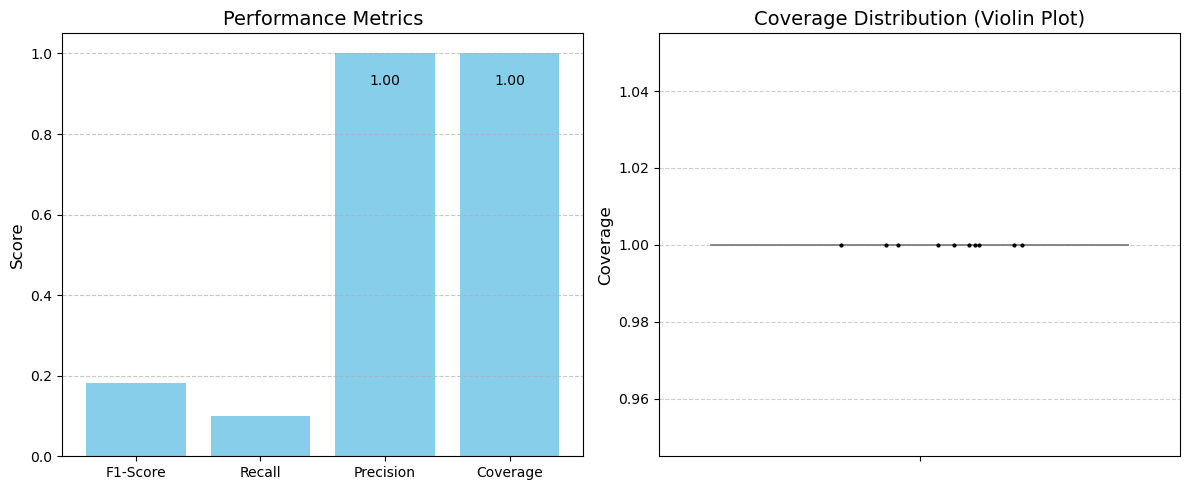

In [5]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

size = 30
motifs_to_discover = 10
threshold = 0.0

columns_to_use = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

# ---- Single Log execution ----
case_id_list = util.util.generate_caseid_list(srrt_plus_log, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
ui_log_encoded_w2v = util.util.encode_word2vec(srrt_plus_log, orderedColumnsList=columns_to_use, vector_size=50)
motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,motifs_to_discover)
print(f"Discovered Motif Indexes: {sorted(motif_indices[0])}")

print(f"Ground Truth:{np.sort(groundTruth)}")

# ---- Measuring Method: Half the Window Size ----
# insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(motif_indices[0]), (size/2))
original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
mean_coverage = 0

if 'coverage' in overlapDF.columns:
    mean_coverage = overlapDF.loc[:, "coverage"].mean()

ground_truth_sum = len(groundTruth)
true_positives = len(original_inserts_indexes)
false_positives = motifs_to_discover - true_positives  # Incorrectly identified motifs
false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
print(f"Recall: {recall}")

# F1-Score
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1_score}")

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Bar Chart ---
metrics = ['F1-Score', 'Recall', 'Precision', 'Coverage']
values = [f1_score, recall, precision, mean_coverage]
axes[0].bar(metrics, values, color='skyblue')
axes[0].set_ylim(0, 1.05)  # Slightly higher to leave space for label

axes[0].set_title('Performance Metrics', fontsize=14)
axes[0].set_ylabel('Score', fontsize=12)

for i, v in enumerate(values):
    if v > 0.5:
        offset = -0.05 if v > 0.98 else 0.02  # Push label down if bar is too high
        axes[0].text(i, v + offset, f"{v:.2f}", ha='center', va='top' if offset < 0 else 'bottom', fontsize=10)

axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- Violin Plot with Points for IoU ---
sns.violinplot(y=overlapDF["coverage"], ax=axes[1], inner=None, color='lightblue')
sns.stripplot(y=overlapDF["coverage"], ax=axes[1], color='black', size=3, jitter=0.2)
axes[1].set_title("Coverage Distribution (Violin Plot)", fontsize=14)
axes[1].set_ylabel("Coverage", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## 1.B. Clustering of discovered Routines

DBSCAN Clustering of the identified routines from the data of the previous step. So executed 1.A. first.

c:\Users\tomho\anaconda3\envs\timeSeriesData\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


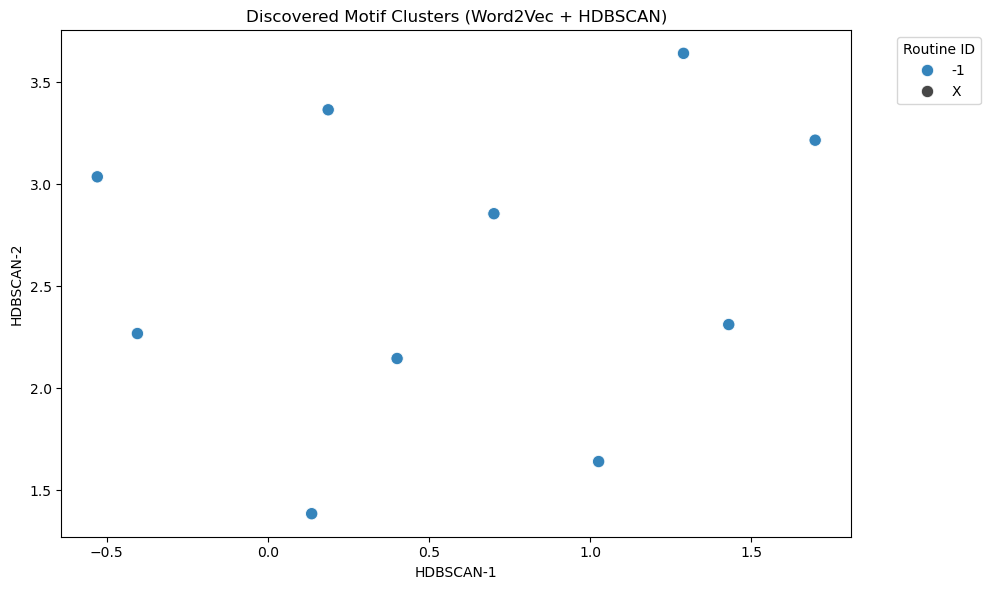


Routine -1 (total motifs: 10):
  Length 62: 10 motifs (100.0%)

Routine -1 (total motifs: 10):
Lengths in [26–36]: 0 motifs (0.0%)
Lengths in [56–66]: 10 motifs (100.0%)


In [6]:
# ---- Clustering ----
def cluster_motifs_with_word2vec(ui_log: pd.DataFrame, motif_starts: list[int], window_size: int) -> pd.DataFrame:
    w2v_columns = [col for col in ui_log.columns if col.startswith("w2v_")]
    
    motif_vectors = []
    for start in motif_starts:
        window = ui_log.loc[start:start + window_size - 1, w2v_columns]
        if len(window) < window_size:
            continue
        mean_vector = window.mean().values
        motif_vectors.append((start, mean_vector))

    starts = [entry[0] for entry in motif_vectors]
    X = [entry[1] for entry in motif_vectors]
    X_scaled = StandardScaler().fit_transform(X)

    clustering = DBSCAN(eps=1.2, min_samples=2, metric='euclidean')
    labels = clustering.fit_predict(X_scaled)

    return pd.DataFrame({
        "start_index": starts,
        "routine_id": labels,
        "embedding": X  # Keep for reuse in UMAP
    })

# ---- Plotting Function ----
def plot_motif_clusters(df_clusters: pd.DataFrame):
    X = np.vstack(df_clusters["embedding"].values)
    
    reducer = umap.UMAP(random_state=42)
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=X_umap[:, 0],
        y=X_umap[:, 1],
        hue=df_clusters["routine_id"],
        palette="tab10",
        style=(df_clusters["routine_id"] == -1).map({True: "X", False: "o"}),
        alpha=0.9,
        s=80
    )
    plt.title("Discovered Motif Clusters (Word2Vec + HDBSCAN)")
    plt.xlabel("HDBSCAN-1")
    plt.ylabel("HDBSCAN-2")
    plt.legend(title="Routine ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---- Example Usage ----
# Date: ui_log = your full DataFrame with word2vec columns
#          motif_starts = list of discovered motif start indices
#          window_size = length of each motif

df_clusters = cluster_motifs_with_word2vec(ui_log_encoded_w2v, overlapDF["discoveredMotif"].tolist(), size)
plot_motif_clusters(df_clusters)

# Create a mapping from start_index to length
length_map = dict(zip(overlapDF["discoveredMotif"], overlapDF["groundTruthLength"]))

# Add 'length' to each motif in df_clusters
df_clusters["length"] = df_clusters["start_index"].map(length_map)

# ---- Print cluster metrics ----
# Group and count motif lengths per cluster
cluster_length_counts = df_clusters.groupby("routine_id")["length"].value_counts()

# Normalize to get total motifs per cluster
cluster_totals = df_clusters.groupby("routine_id")["length"].count()

# Print with percentages
for routine_id, group in cluster_length_counts.groupby(level=0):
    total = cluster_totals[routine_id]
    print(f"\nRoutine {routine_id} (total motifs: {total}):")
    for (rid, length), count in group.items():
        percentage = (count / total) * 100
        print(f"  Length {length}: {count} motifs ({percentage:.1f}%)")

# SR and RT boundaries from Leno Paper to define the cluster range
short_range = (26, 36)  # 31 ± 5
long_range = (56, 66)   # 61 ± 5

# Group by cluster
clustered = df_clusters.groupby("routine_id")["length"]

# Compute and print
for routine_id, lengths in clustered:
    total = len(lengths)
    count_short = sum(lengths.between(*short_range))
    count_long = sum(lengths.between(*long_range))
    
    percent_short = (count_short / total) * 100 if total > 0 else 0
    percent_long = (count_long / total) * 100 if total > 0 else 0
    
    print(f"\nRoutine {routine_id} (total motifs: {total}):")
    print(f"Lengths in [26–36]: {count_short} motifs ({percent_short:.1f}%)")
    print(f"Lengths in [56–66]: {count_long} motifs ({percent_long:.1f}%)")

# ---- Save the clusters ----
# df_clusters.to_csv(f'ExperimentResult/ClusteredMotifs_{log_to_discover_name}_{timestamp}.csv', index=False)

## 2. Automated Experiment for multiple window sizes

### Word2Vec Encoding Based

Experiment A) Impact of column selection on discovery result (EX1)

Experiment B) Impact of window size on discovery result (EX2)

Experiment C) Impact of discovered motifs on discovery result (EX3)

#### A) Fixed Window Size, Fixed Motif to Discover, Different Context Columns

w_s = 30, t=10, Context Columns fluctuating

In the paper referred to as EX1

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

# All Context Columns
ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 30
NumberOfMotifsToDiscover = 10
threshold = 0.8

#########################
# ---- Do not change ----
#########################
# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])


case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----

discovery_repeat = False
start = 1
for i in range(start, len(ContextColumns) + 1):
    contextColumnSelection = ContextColumns[:i]
    ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=contextColumnSelection, vector_size=50)

    print(f"Processing Columns: {contextColumnSelection}")
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,NumberOfMotifsToDiscover)

    discovered_set = set(motif_indices[0])
    
    if discovered_set or discovery_repeat:

        # insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
        original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
        mean_coverage = 0

        if 'coverage' in overlapDF.columns:
            mean_coverage = overlapDF.loc[:, "coverage"].mean()
        else:
            mean_coverage = 0

        true_positives = len(original_inserts_indexes)
        false_positives = NumberOfMotifsToDiscover - true_positives
        false_negatives = ground_truth_sum - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Filter the length of the discovered motifs
        filtered_df = cases_df[cases_df["start_index"].isin(original_inserts_indexes)]
        motif_length_list = list(filtered_df[["start_index", "length"]].itertuples(index=False, name=None))

        # print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}, Precision: {precision}, Recall: {recall}, IuO: {mean_iou}.")
        results.append({
            'window_size': size,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'mean_coverage': mean_coverage,
            'discovered_indexes': sorted(set(overlapDF[["groundTruthStart", "groundTruthLength"]].itertuples(index=False, name=None))),
            'discovered_motif_spots': set(discovered_motif_spots),
            'motif_count': NumberOfMotifsToDiscover,
            'context_columns': contextColumnSelection,
            'context_columns_count': i
        })
        discovery_repeat = False
    else:
        discovery_repeat = True


# ---- Save the results ----
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime("%y%m%d_%H%M")
results_df.to_csv(f'ExperimentResult/ColumnScore-EX1_{log_to_discover_name}_{timestamp}.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['context_columns_count'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['context_columns_count'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['context_columns_count'], results_df['precision'], marker='+', linewidth=2, label='Precision')
plt.plot(results_df['context_columns_count'], results_df['mean_coverage'], marker='s', linewidth=2, label='Mean Coverage')

plt.title('Effect of Context Parameters', fontsize=16)
plt.xlabel('Context Columns Count', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['motif_count'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
# ---- Save to file ----
plt.savefig(f"ExperimentResult/ColumnScore-EX1_{log_to_discover_name}_plot_{timestamp}.png", dpi=300, bbox_inches='tight')

Processing Columns: ['targetApp']


### B) Fixed Number of motifs with changing window size
Fixed t=10, w_S = range(26,68)

In the paper referred to as EX2

Processing size: 26
Processing size: 27
Processing size: 28
Processing size: 29
Processing size: 30
Processing size: 31
Processing size: 32
Processing size: 33
Processing size: 34
Processing size: 35
Processing size: 36
Processing size: 37
Processing size: 38
Processing size: 39
Processing size: 40
Processing size: 41
Processing size: 42
Processing size: 43
Processing size: 44
Processing size: 45
Processing size: 46
Processing size: 47
Processing size: 48
Processing size: 49
Processing size: 50
Processing size: 51
Processing size: 52
Processing size: 53
Processing size: 54
Processing size: 55
Processing size: 56
Processing size: 57
Processing size: 58
Processing size: 59
Processing size: 60
Processing size: 61
Processing size: 62
Processing size: 63
Processing size: 64
Processing size: 65
Processing size: 66
Processing size: 67
Processing size: 68


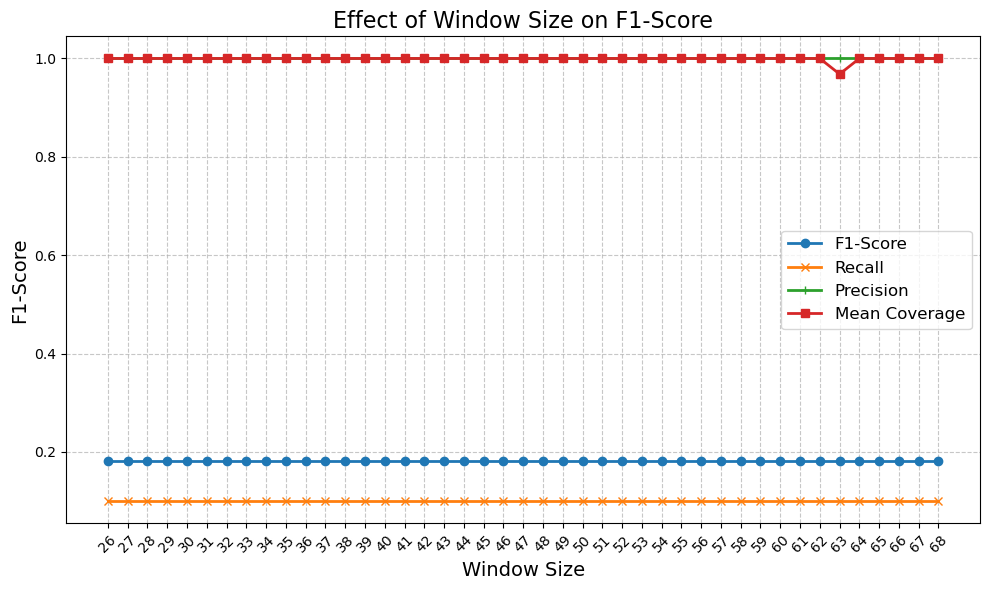

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

NumberOfMotifsToDiscover = 10
threshold = 0.8

#########################
# ---- Do not change ----
#########################
# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=ContextColumns, vector_size=50)

# ---- Generate ground truth ----
case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
size = 26
discovery_repeat = False
while size <= 68:
    print(f"Processing size: {size}")
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,NumberOfMotifsToDiscover)

    discovered_set = set(motif_indices[0])
    if discovered_set or discovery_repeat:

        # insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
        original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
        mean_coverage = 0
        
        if 'coverage' in overlapDF.columns:
            mean_coverage = overlapDF.loc[:, "coverage"].mean()
        else:
            mean_coverage = 0

        true_positives = len(original_inserts_indexes)
        false_positives = NumberOfMotifsToDiscover - true_positives
        false_negatives = ground_truth_sum - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Filter the length of the discovered motifs
        filtered_df = cases_df[cases_df["start_index"].isin(original_inserts_indexes)]
        motif_length_list = list(filtered_df[["start_index", "length"]].itertuples(index=False, name=None))

        # print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}, Precision: {precision}, Recall: {recall}, IuO: {mean_iou}.")
        results.append({
            'window_size': size,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'mean_coverage': mean_coverage,
            'discovered_indexes': set(overlapDF[["groundTruthStart", "groundTruthLength"]].itertuples(index=False, name=None)),
            'discovered_motif_spots': set(discovered_motif_spots),
            'motif_count': NumberOfMotifsToDiscover
        })
        size += 1
        discovery_repeat = False
    else:
        discovery_repeat = True


# ---- Save the results ----
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime("%y%m%d_%H%M")
results_df.to_csv(f'ExperimentResult/windowSize-EX2_{log_to_discover_name}_{timestamp}.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['window_size'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['window_size'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['window_size'], results_df['precision'], marker='+', linewidth=2, label='Precision')
plt.plot(results_df['window_size'], results_df['mean_coverage'], marker='s', linewidth=2, label='Mean Coverage')

plt.title('Effect of Window Size on F1-Score', fontsize=16)
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['window_size'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
# ---- Save to file ----
plt.savefig(f"ExperimentResult/windowSize-EX2_{log_to_discover_name}_plot_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

### C) Fixed Window Size, Flexible Number of motifs t

w_s = 30 and t=[5,10,20,30,40,50,60,70,80,90,100]

In the paper referred to as EX3

In [ ]:
# ---- Inputs ----
# Select the log to discover motifs from
# log_to_discover = srrt_plus_log
# log_to_discover_name = "SRRT_Plus"
# OR
log_to_discover = srrt_parallel_log
log_to_discover_name = "SRRT_Parallel"

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 30
threshold = 0.8

#########################
# ---- Do not change ----
#########################
# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

ui_log_encoded_w2v = util.util.encode_word2vec(log_to_discover, orderedColumnsList=ContextColumns, vector_size=50)

case_id_list = util.util.generate_caseid_list(log_to_discover, column="caseid")
cases_df = pd.DataFrame(case_id_list, columns=["caseid", "start_index", "length"])
groundTruth = cases_df["start_index"].tolist()
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
discoverable_motifs = [5,10,20,30,40,50,60,70,80,90,100]
discovery_repeat = False
for NumberOfMotifsToDiscover in discoverable_motifs:
    print(f"Processing Motif Count: {NumberOfMotifsToDiscover}")
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,NumberOfMotifsToDiscover)  

    discovered_set = set(motif_indices[0])
    if discovered_set or discovery_repeat:

        # insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
        original_inserts_indexes, discovered_motif_spots, overlapDF = util.util.compute_discovery_coverage(case_id_list, set(motif_indices[0]), size, threshold=threshold)
        mean_coverage = 0
        if 'coverage' in overlapDF.columns:
            mean_coverage = overlapDF.loc[:, "coverage"].mean()
        else:
            mean_coverage = 0

        true_positives = len(original_inserts_indexes)
        false_positives = NumberOfMotifsToDiscover - true_positives
        false_negatives = ground_truth_sum - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Filter the length of the discovered motifs
        # filtered_df = cases_df[cases_df["start_index"].isin(original_inserts_indexes)]
        # motif_length_list = list(filtered_df[["start_index", "length"]].itertuples(index=False, name=None))

        # print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}, Precision: {precision}, Recall: {recall}, IuO: {mean_iou}.")
        results.append({
            'window_size': size,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'mean_coverage': mean_coverage,
            'discovered_indexes': set(overlapDF[["groundTruthStart", "groundTruthLength"]].itertuples(index=False, name=None)),
            'discovered_motif_spots': set(discovered_motif_spots),
            'motif_count': NumberOfMotifsToDiscover
        })
        discovery_repeat = False
    else:
        discovery_repeat = True


# ---- Save the results ----
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime("%y%m%d_%H%M")
results_df.to_csv(f'ExperimentResult/NoOfDiscovery-EX3_{log_to_discover_name}_{timestamp}.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['motif_count'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['motif_count'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['motif_count'], results_df['precision'], marker='+', linewidth=2, label='Precision')
plt.plot(results_df['motif_count'], results_df['mean_coverage'], marker='s', linewidth=2, label='Mean Coverage')

plt.title('Effect of Motif Discover Count', fontsize=16)
plt.xlabel('Motif Discovery Count', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['motif_count'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
# ---- Save to file ----
plt.savefig(f"ExperimentResult/NoOfDiscovery-EX3_{log_to_discover_name}_plot_{timestamp}.png", dpi=300, bbox_inches='tight')

NameError: name 'srrt_parallel_log' is not defined

# 4. Archive

Old encoding method. Improved after reviewer feedback and experiment results in the notebook above.

## 4.1. Hot Encoding Method(s)

Based on the context columns the discovery will be executed

In [ ]:
log_to_discover = srrt_plus_log
#log_to_discover = srrt_parallel_log

# ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id"] # Leno Attributes
ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 25
NumberOfMotifsToDiscover = 25

# ---- Generating Ground Truth ----
groundTruth = util.util.generate_caseid_list(log_to_discover)

# ---- Reading the File ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])
uiLog_Encoding_method = 3 # 1=Hierarchy Encoding, 2=Co-Occurrance Encoding, 3=Hot Encoding

uiLog = util.util.encoding_UiLog(log_to_discover,orderedColumnsList=ContextColumns,encoding=uiLog_Encoding_method)

# ---- Time Series Mining ----
tm_matrix, event_series = util.util.discover_motifs(uiLog, window_size=size, normalize=True)

print(f"event_series shape: {event_series.shape}")
print(f"tm_matrix shape: {tm_matrix.shape}")
print(f"tm_matrix[:,0] shape: {tm_matrix[:,0].shape}")

# The motifs have to be exclusive, thus, no one activity must be part of a routine already discovered
config.STUMPY_EXCL_ZONE_DENOM = 1  # The exclusion zone is i ± m
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=NumberOfMotifsToDiscover, cutoff=5)
# Identify the outlier
discord_idx = np.argsort(tm_matrix[:, 0])[-1]
print(f"Discovered: {np.sort(top_motifs[1][0])}")

event_series shape: (9594,)
tm_matrix shape: (9570, 4)
tm_matrix[:,0] shape: (9570,)
Discovered: [   6   32  110  136  189  215  270  296  351  377  432  458  511  537
  593  673  699  754  780  835  861  914  940  995 1021]


## 4.2. Quality Measures

In [ ]:
print(f"Ground Truth:{np.sort(groundTruth)}")

# For 1-dim time series
insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(top_motifs[1][0]), (size/2))

ground_truth_sum = len(groundTruth)
true_positives = len(insert_spots)
false_positives = NumberOfMotifsToDiscover - true_positives  # Incorrectly identified motifs
false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
print(f"Recall: {recall}")

# F1-Score
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1_score}")

## 4.3. Automated Experiment for multiple window sizes
### A. Hot Encoding Based Multi Window Experiment

The following code tests multiple window sizes againts the encoding method and number of motifs to be discovered and visualizes the F1-Score trend afterwards.

In [ ]:
# ---- Inputs ----
log_to_discover = srrt_plus_log
# log_to_discover = srrt_parallel_log

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]
ContextColumns = ['eventType', 'targetApp', 'target.tagName', 'target.name']


NumberOfMotifsToDiscover = 10
uiLog_Encoding_method = 3  # 1=Hierarchy Encoding, 2=Co-Occurrance Encoding, 3=Hot Encoding

# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

uiLog = util.util.encoding_UiLog(log_to_discover, orderedColumnsList=ContextColumns, encoding=uiLog_Encoding_method)


groundTruth = util.util.generate_caseid_list(log_to_discover)
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
for size in range(25, 66):
    uiLog = util.util.encoding_UiLog(log_to_discover, orderedColumnsList=ContextColumns, encoding=uiLog_Encoding_method)
    tm_matrix, event_series = util.util.discover_motifs(uiLog, window_size=size, normalize=True)
    
    config.STUMPY_EXCL_ZONE_DENOM = 1
    top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:, 0], min_neighbors=1, max_matches=NumberOfMotifsToDiscover, cutoff=5)
    
    discovered_set = set(top_motifs[1][0])
    insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
    # insert_spots, motif_spots, overlapDF = util.util.compare_sets_IoU(groundTruth_set, discovered_set, window_size=size, iou_threshold=0.5)

    true_positives = len(insert_spots)
    false_positives = NumberOfMotifsToDiscover - true_positives
    false_negatives = ground_truth_sum - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    results.append({
        'window_size': size,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

    # print("Execution completed for window size:" + str(size))

# ---- Save the results ----
results_df = pd.DataFrame(results)
results_df.to_csv('motif_discovery_window_size_experiment.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['window_size'], results_df['f1_score'], marker='o', linewidth=2)

plt.title('Effect of Window Size on F1-Score', fontsize=16)
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['window_size'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Visualisation

Not Maintained

In [ ]:
# ---- DFG Mining ----
caseuiLog = util.util.reduceLogToDiscovered(uiLog,top_motifs[1][0],size)
end_time = time.time()

cols = ["targetApp","eventType"]
caseuiLog["concept:name"] = caseuiLog[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
caseuiLog["time:timestamp"] = caseuiLog["timeStamp"]
caseuiLog['case:concept:name'] = caseuiLog['case:concept:name'].astype('int64')
pm4pyDf = pm4py.format_dataframe(caseuiLog)
uiLogDFG, start_activities, end_activities = pm4py.discover_dfg(pm4pyDf)
pm4py.view_dfg(uiLogDFG, start_activities, end_activities)

# ---- Motif Visualisation ----
starting_row = 0
ending_row = len(uiLog)-1
ids = uiLog.loc[starting_row:ending_row,'tuple:id'].tolist()
rows = [i for i in range(len(uiLog.loc[starting_row:ending_row,'tuple:id']))]

#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Routine) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
# Plot Matrix profiles
axs2[2].set_xlabel('Activity', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    #axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
for i, val in enumerate(top_motifs[1][0]):
    colorPlot = 'C' + str(i)
    ax.plot(event_series[val:val+size], color=colorPlot, label=f"Motif {i}")
    
plt.legend(loc="best",fontsize=10)
plt.show()